In [5]:
# (Run in your shell)
!pip install torchvision


In [8]:
import os, random, shutil
from pathlib import Path

def create_train_val_test_split(
    src_root: str,
    dst_root: str,
    train_ratio: float = 0.7,
    val_ratio:   float = 0.15,
    test_ratio:  float = 0.15,
    seed:        int   = 42
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    random.seed(seed)
    src = Path(src_root)
    dst = Path(dst_root)

    # Make directories
    for split in ("train", "validation", "test"):
        for cls in src.iterdir():
            if cls.is_dir():
                (dst / split / cls.name).mkdir(parents=True, exist_ok=True)

    # Distribute images
    for cls_dir in src.iterdir():
        if not cls_dir.is_dir(): 
            continue
        images = list(cls_dir.glob("*.[jJpP][pPnN][gG]"))
        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)

        splits = {
            "train":      images[:n_train],
            "validation": images[n_train:n_train + n_val],
            "test":       images[n_train + n_val:]
        }

        for split, imgs in splits.items():
            for img in imgs:
                shutil.copy2(img, dst / split / cls_dir.name / img.name)

# Usage (run once):
create_train_val_test_split("data/flowers", "data/flowers_split")


In [17]:
import os, cv2
import torch
from torch.utils.data import Dataset, DataLoader

class FlowersDataset(Dataset):
    def __init__(self, root_dir: str, split: str = "train", img_size: int = 64):
        base = os.path.join(root_dir, split)
        self.items = []
        self.class_to_idx = {}
        for idx, cls in enumerate(sorted(os.listdir(base))):
            self.class_to_idx[cls] = idx
            cls_dir = os.path.join(base, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith((".jpg", ".png")):
                    self.items.append((os.path.join(cls_dir, fname), idx))
        self.img_size = img_size

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        t   = torch.from_numpy(img).permute(2,0,1).float().div(255.0)
        t   = t.sub(0.5).div(0.5)  # normalize to [-1,1]
        return t, label

# Prepare loaders
DATA_DIR   = "data/flowers_split"
IMG_SIZE   = 64
BATCH_SIZE = 32

train_ds = FlowersDataset(DATA_DIR, split="train",      img_size=IMG_SIZE)
val_ds   = FlowersDataset(DATA_DIR, split="validation", img_size=IMG_SIZE)
test_ds  = FlowersDataset(DATA_DIR, split="test",       img_size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



In [24]:
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.qnn import TorchLayer
import torch

# Updated quantum configuration
n_qubits   = 8
n_q_layers = 4

dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_q_layers, n_qubits, 3)}
qnode         = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="backprop")
quantum_layer = TorchLayer(qnode, weight_shapes)

# Sanity check
dummy = torch.rand(4, n_qubits)
print("Quantum layer output:", quantum_layer(dummy).shape)  # → [4, 8]


Quantum layer output: torch.Size([4, 8])


In [ ]:
import torch.nn as nn

class HybridCNNVQC(nn.Module):
    def __init__(self, n_classes, quantum_layer, n_qubits):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(64, n_qubits), nn.Tanh()
        )
        self.quantum = quantum_layer
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 32), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(32, n_classes)
        )

    def forward(self, x):
        feats = self.cnn(x)                         # [B, n_qubits] in [-1,1]
        angles = (feats + 1) * (torch.pi / 2)       # → [0, π]
        q_out = self.quantum(angles)                # [B, n_qubits]
        return self.classifier(q_out)
    



In [48]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define these beforehand:
# - quantum_layer: your VQC quantum torch module
# - n_qubits: number of qubits (e.g. 5)
# - train_ds: your training dataset

# Instantiate model
model = HybridCNNVQC(n_classes=len(train_ds.class_to_idx), quantum_layer=quantum_layer, n_qubits=n_qubits)

# Define loss and optimizer separately
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# Set batch size + dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# OneCycle scheduler
EPOCHS = 70
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-2,
    total_steps=EPOCHS * len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

# AMP scaler
scaler = GradScaler()


/var/folders/c0/ww7n2sss14n7fhrmnhrcmdt40000gn/T/ipykernel_5447/503024268.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [50]:
import torch
from torch.cuda.amp import autocast, GradScaler
import json

scaler = GradScaler()
training_logs = []

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    correct = total = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        pred_labels = preds.argmax(dim=1)
        correct += (pred_labels == y).sum().item()
        total += y.size(0)
    return 100 * correct / total

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast():
            preds = model(x)
            loss = criterion(preds, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

        # Accumulate training accuracy
        pred_labels = preds.argmax(dim=1)
        correct += (pred_labels == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    val_acc = evaluate(model, val_loader, device)
    avg_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save log
    training_logs.append({
        "epoch": epoch + 1,
        "loss": round(avg_loss, 4),
        "train_accuracy": round(train_acc, 2),
        "val_accuracy": round(val_acc, 2)
    })

# Save to JSON
with open("training_log.json", "w") as f:
    json.dump(training_logs, f, indent=4)


/var/folders/c0/ww7n2sss14n7fhrmnhrcmdt40000gn/T/ipykernel_5447/3105633123.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/var/folders/c0/ww7n2sss14n7fhrmnhrcmdt40000gn/T/ipykernel_5447/3105633123.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Loss: 1.6167 | Train Acc: 18.71% | Val Acc: 18.17%
Epoch 02 | Loss: 1.5997 | Train Acc: 25.97% | Val Acc: 32.92%
Epoch 03 | Loss: 1.5701 | Train Acc: 33.16% | Val Acc: 34.16%
Epoch 04 | Loss: 1.4945 | Train Acc: 36.17% | Val Acc: 36.18%
Epoch 05 | Loss: 1.3849 | Train Acc: 38.46% | Val Acc: 41.77%
Epoch 06 | Loss: 1.3063 | Train Acc: 42.23% | Val Acc: 43.63%
Epoch 07 | Loss: 1.2715 | Train Acc: 43.95% | Val Acc: 50.47%
Epoch 08 | Loss: 1.2159 | Train Acc: 46.51% | Val Acc: 53.88%
Epoch 09 | Loss: 1.1797 | Train Acc: 48.92% | Val Acc: 54.81%
Epoch 10 | Loss: 1.1739 | Train Acc: 50.02% | Val Acc: 54.50%
Epoch 11 | Loss: 1.1425 | Train Acc: 52.50% | Val Acc: 60.56%
Epoch 12 | Loss: 1.1301 | Train Acc: 52.14% | Val Acc: 52.48%
Epoch 13 | Loss: 1.0943 | Train Acc: 53.69% | Val Acc: 63.51%
Epoch 14 | Loss: 1.0958 | Train Acc: 55.22% | Val Acc: 62.11%
Epoch 15 | Loss: 1.0675 | Train Acc: 55.75% | Val Acc: 60.25%
Epoch 16 | Loss: 1.0253 | Train Acc: 57.97% | Val Acc: 63.66%
Epoch 17

In [51]:
torch.save(model.state_dict(), "flowerPred_vqc_model.pth")

In [52]:
# Load model state
model.load_state_dict(torch.load("flowerPred_vqc_model.pth", map_location=device))
model.eval()

# Evaluate on test data
correct = 0
total = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with autocast():
            outputs = model(x_batch)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


/var/folders/c0/ww7n2sss14n7fhrmnhrcmdt40000gn/T/ipykernel_5447/238909146.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("flowerPred_vq

Test Accuracy: 72.17%


✅ Parsed 100 epochs and saved to training_log.json


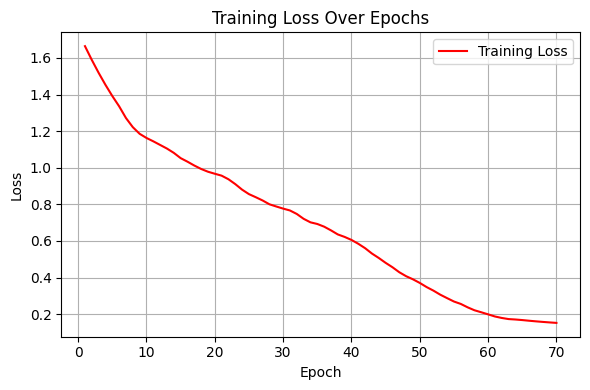

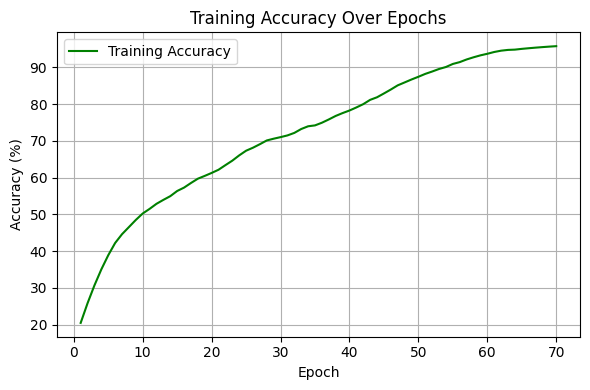

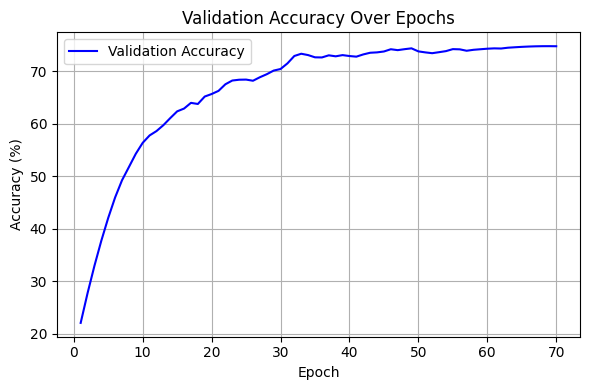

In [53]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import json

# Load training log
with open("training_log.json", "r") as f:
    log_data = json.load(f)

# Extract data
epochs = [entry["epoch"] for entry in log_data]
loss = [entry["loss"] for entry in log_data]
train_acc = [entry["train_accuracy"] for entry in log_data]
val_acc = [entry["val_accuracy"] for entry in log_data]

# Apply Savitzky-Golay smoothing
def smooth(values):
    window = min(len(values) // 2 * 2 - 1, 11)
    return savgol_filter(values, window_length=window, polyorder=2) if window >= 3 else values

smoothed_loss = smooth(loss)
smoothed_train_acc = smooth(train_acc)
smoothed_val_acc = smooth(val_acc)

# --- Plot 1: Training Loss ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, smoothed_loss, label="Training Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_loss.png")
plt.show()

# --- Plot 2: Training Accuracy ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, smoothed_train_acc, label="Training Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_accuracy.png")
plt.show()

# --- Plot 3: Validation Accuracy ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, smoothed_val_acc, label="Validation Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("validation_accuracy.png")
plt.show()
